# Day 21 notebook
The objectives of this notebook are to practice

* The K-means algorithm
* Selecting the number of clusters (K)

## Modules for this activity

In [1]:
# standard library modules
import random                        # for sample
import itertools                     # for count
import sys                           # for stderr
import math                          # for log

# third-party modulees
import ipywidgets                    # for interact
from matplotlib import pyplot as plt # for plotting

# course modules
import clusterplot

## Toy dataset
In this notebook we will use small toy dataset to explore how the K-means algorithm works.  This dataset consists of 100 2-dimensional profiles.  You can think of each of these profiles as a measurement of the RNA abundance of two genes.  Real gene expression profiles are typically of much higher dimension (on the order of thousands to tens of thousdands of dimensions, corresponding to number of genes in a genome), but for simplicity in understanding the K-means algorithm, we will consider just two dimensions.

We will read this dataset from a file in the code below:

In [2]:
sample_profiles_filename = "sample_profiles.txt"
sample_profiles = [tuple(map(float, line.split())) for line in open(sample_profiles_filename)]

Here is a static visualization of this dataset:

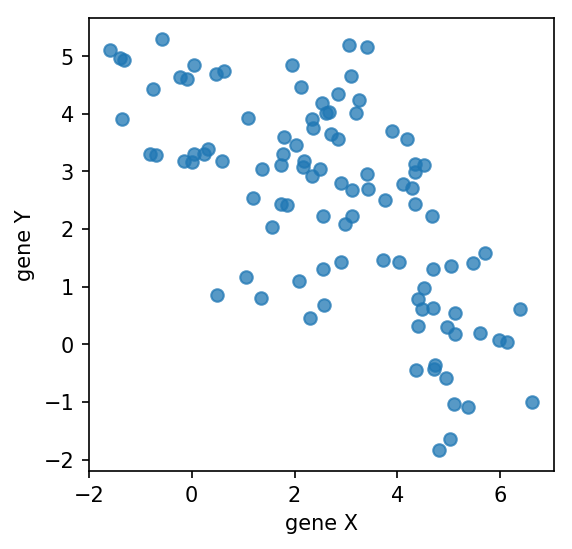

In [3]:
clusterplot.plot_profiles(sample_profiles)

## The K-means algorithm
In this activity we will implement the K-means clustering algorithm and visualize it in action.  Below is an implemention of the high-level aspects of the algorithm.  The high-level implementation is broken into two pieces:
* `cluster_kmeans_iterator`: performs one run of the algorithm until termination, and provides an iterator over the results after each iteration.  This will be used for visualizing the algorithm later in this activity.
* `cluster_kmeans`: a simple interface to the full algorithm. It runs through the the entire iterator provided by  `cluster_kmeans_iterator` and returns the final results. It can optionally run the algorithm multiple times with random initializations and return the best result.

The pieces that are missing are the two main functions called within `cluster_kmeans_iterator`, which are:
* `closest_center`: determines the closest cluster center to a given profile
* `mean_profile`: computes the center of a cluster given the profiles assigned to it

Take a look over the high-level functions and then provide implementations to these core functions in the first two problems.

In [4]:
def cluster_kmeans(profiles, k, initial_f=None, max_iterations=None, num_runs=1):
    """Runs the K-means algorithm, returning the final cluster assignments and centers.
    
    Args:
        profiles: a list of profiles (vectors), with each profile represented as tuple
        k: the number of clusters to find
        initial_f: the initial cluster centers (optional)
        max_iterations: the maximum number of iterations for the algorithm
        num_runs: # of runs of the algorithm with random intializations
    Returns:
        A tuple (C, f), where C is a list with C[i] giving the index of the cluster to
        which profile i is assigned, and f is a list of cluster centers (tuples) (e.g., f[j] 
        is the cluster center for cluster j).
    """
    best_C, best_f, best_score = None, None, float("inf")
    for run in range(num_runs):
        # iterate until termination
        for C, f in cluster_kmeans_iterator(profiles, k, initial_f, max_iterations):
            pass
        score = within_cluster_scatter(profiles, C, f)
        if score < best_score:
            best_C, best_f, best_score = C, f, score

    return best_C, best_f

def cluster_kmeans_iterator(profiles, k, initial_f=None, max_iterations=None):
    """An iterator over the results the K-means algorithm after each of its iterations.
    
    The arguments and yielded values are the same as for cluster_kmeans.
    """
    
    # randomly select k of the input profiles as centers if initial_f not given
    f = initial_f if initial_f else random.sample(profiles, k)
    
    # keep track of the last cluster assignments
    last_C = None
    
    for iteration in itertools.count(1):
        # stop if we have reached the maximum number of iterations
        if max_iterations is not None and iteration > max_iterations:
            print("Warning: max iterations reached", file=sys.stderr)
            break
        
        # (re)compute closest cluster for each profile
        C = [closest_center(profile, f) for profile in profiles]
        
        # terminate if the cluster assignments do not change
        if C == last_C: break

        # (re)compute cluster centers
        # create lists of profiles assigned to each cluster
        clusters = group_by_cluster_assignment(profiles, C, k)
        
        # compute the means of each cluster
        # if a cluster has no longer has points assigned to it, use its last center
        f = [mean_profile(cluster) if cluster else f[i] for i, cluster in enumerate(clusters)]
        
        # yield the current results for possible inspection
        yield C, f
        
        last_C = C

def group_by_cluster_assignment(objects, assignments, k):
    """Returns a list of lists of the objects assigned to each cluster."""
    clusters = [[] for i in range(k)]
    for obj, cluster_index in zip(objects, assignments):
        clusters[cluster_index].append(obj)
    return clusters

def squared_euclidean_distance(p1, p2):
    """The square of the Euclidean distances between two profiles."""
    return sum((e1 - e2)**2 for e1, e2 in zip(p1, p2))

def euclidean_distance(p1, p2):
    """The Euclidean distance between two profiles."""
    return math.sqrt(squared_euclidean_distance(p1, p2))

def within_cluster_scatter(profiles, cluster_assignments, centers):
    """Computes the within-cluster scatter for a given clustering."""
    return sum(squared_euclidean_distance(p, centers[cluster_index])
               for p, cluster_index in zip(profiles, cluster_assignments))

## PROBLEM 1: Computing the closest cluster center to a profile (1 POINT)
Implement the `closest_center` function, which determines the closest cluster center to a given profile.  Your function should use the `squared_euclidean_distance` function defined above.

In [5]:
def closest_center(profile, centers):
    """Returns the index of the cluster center that is closest to profile.
    
    If multiple centers are equally close, the smallest index is returned.
    Args:
        profile: a tuple representing the query profile
        centers: a list of tuples representing the centers of each cluster.
    Returns:
        The index of the center that is closest (in Euclidean distance) to the query profile."""
    ### BEGIN SOLUTION
    distances = [squared_euclidean_distance(profile, center) for center in centers]
    return distances.index(min(distances))
    ### END SOLUTION

In [6]:
# tests for closest_center
assert closest_center((2, 3), [(1, 6), (2, 8), (3, 4)]) == 2
assert closest_center((2, 5), [(1, 6), (2, 8), (3, 4)]) == 0
assert closest_center((2, 7), [(1, 6), (2, 8), (3, 4)]) == 1
assert closest_center((2, 7), [(1, 6)]) == 0
assert closest_center((3, 1, 2), [(4, 6, 1), (-2, 1, 2)]) == 1
print("SUCCESS: all tests for closest_center passed")

SUCCESS: all tests for closest_center passed


## PROBLEM 2: Computing the center of a cluster (1 POINT)
Implement the `mean_profile` function, which determines the center (mean profile) of a single cluster of profiles.

In [7]:
def mean_profile(profiles):
    """Computes the center (mean) of a cluster of the given profiles.
    
    Args:
        profiles: a list of profiles (tuples)
    Returns:
        a tuple representing the mean of the profiles."""
    ### BEGIN SOLUTION
    n = len(profiles)
    return tuple(s / n for s in map(sum, zip(*profiles)))
    ### END SOLUTION    

In [8]:
# tests for mean_profile
assert mean_profile([(1, 6), (2, 8), (3, 4)]) == (2, 6)
assert mean_profile([(1, 6), (3, 4)]) == (2, 5)
assert mean_profile([(1, 6)]) == (1, 6)
assert mean_profile([(3, 1, 2), (5, 7, 2), (-2, 1, 2)]) == (2, 3, 2)
assert mean_profile([(3,), (5,), (-2,)]) == (2,)
print("SUCCESS: all tests for mean_profile passed")

SUCCESS: all tests for mean_profile passed


## Visualization of the K-means algorithm

Now that you have filled in the missing pieces of our K-means implementation, let's see the algorithm in action.  It will be helpful to visualize the state of the algorithm at each of its iterations.  Below is a function that we will use to visualize the progress of the K-means algorithm.

In [9]:
def plot_kmeans_iterations(profiles, k, initial_f=None):
    """Produce an interactive plot for visualizing the results of the K-means algorithm at each iteration."""
    iterations = list(cluster_kmeans_iterator(profiles, k, initial_f))
    within_cluster_scatters = [within_cluster_scatter(profiles, C, f) for C, f in iterations]
    def plot_iteration(iteration=0):
        C, f = iterations[iteration]
        scatter = round(within_cluster_scatters[iteration], 1)
        title = "Iteration={}, Within-cluster scatter={}".format(iteration, scatter)
        clusterplot.plot_profiles(profiles, C, f, title=title)
        print("cluster centers:", [tuple(round(x, 1) for x in center) for center in f])
    ipywidgets.interact(plot_iteration, iteration=(0, len(iterations) - 1)) 

And here is an interactive plot of the result of running the K-means algorithm on our toy dataset, with $k = 5$.  Use the slider at the top of the plot to go through the iterations of the algorithm.  The value of the within-cluster scatter objective function is given at the top and the positions of the current cluster centers are printed at the bottom.

In [10]:
plot_kmeans_iterations(sample_profiles, 5)

interactive(children=(IntSlider(value=0, description='iteration', max=10), Output()), _dom_classes=('widget-interact',))

## PROBLEM 3: A "good" run of K-means (1 POINT)

Recall that the K-means algorithm is sensistive to the initial positions of the cluster centers.  In this problem and the next, we will explore this issue by finding intial positions that result in "good" and "bad "clusterings.

For $k = 5$, find a set of initial cluster centers that gives a "good" clustering for the sample points, where a "good" clustering has a within-cluster scatter score less than 100.  One approach here could be to run the `plot_kmeans_iterations` function multiple times (each call uses a different randomly selected set of intial cluster centers) until you find cluster centers that give a "good" clustering.

Assign your list of cluster centers to the variable `good_cluster_centers` below.

In [11]:
### BEGIN SOLUTION TEMPLATE=good_cluster_centers=?
good_cluster_centers = [(3.8, 2.6), (2.4, 3.9), (5.1, 0.1), (1.9, 1.5), (-0.3, 4.1)]
plot_kmeans_iterations(sample_profiles, 5, initial_f=good_cluster_centers)
### END SOLUTION

interactive(children=(IntSlider(value=0, description='iteration', max=0), Output()), _dom_classes=('widget-interact',))

In [12]:
# tests for good_cluster_centers
assert len(good_cluster_centers) == 5
cluster_assignments, centers = cluster_kmeans(sample_profiles, 5, good_cluster_centers)
assert within_cluster_scatter(sample_profiles, cluster_assignments, centers) < 100
print("SUCCESS: all tests for good_cluster_centers passed")

SUCCESS: all tests for good_cluster_centers passed


## PROBLEM 4: A "bad" run of K-means (1 POINT)
For $k = 5$, find a set of initial cluster centers that gives a "bad" clustering for the sample points, where a "bad" clustering has a within-cluster scatter greater than 120.

Assign your list of cluster centers to the variable bad_cluster_centers below.

In [13]:
### BEGIN SOLUTION TEMPLATE=bad_cluster_centers=?
bad_cluster_centers = [(3.9, 2.8), (-0.3, 4.1), (3.8, 1.0), (5.3, -0.4), (2.2, 3.4)]
plot_kmeans_iterations(sample_profiles, 5, initial_f=bad_cluster_centers)
### END SOLUTION

interactive(children=(IntSlider(value=0, description='iteration', max=0), Output()), _dom_classes=('widget-interact',))

In [14]:
# tests for bad_cluster_centers
assert len(bad_cluster_centers) == 5
cluster_assignments, centers = cluster_kmeans(sample_profiles, 5, bad_cluster_centers)
assert within_cluster_scatter(sample_profiles, cluster_assignments, centers) > 120
print("SUCCESS: all tests for bad_cluster_centers passed")

SUCCESS: all tests for bad_cluster_centers passed


## Selecting the number of clusters (K)

A common issue in flat clustering is how to select $K$, the number of clusters.  For K-means clustering one approach is to use a penalized objective function, with a penalty term that is a function of the number of clusters.  The general form of the penalized objective function for a clustering $C$ that has $K$ clusters is:

$penalized\_objective(C, K) = within\_cluster\_scatter(C) + \lambda K$

where $\lambda$ is an user-set parameter.  Two statistically principed values for lambda are:

* Akaike Information Criterion (AIC): $\lambda = 2M$, where $M$ is the dimension of the profiles
* Bayesian Information Criterion (BIC): $\lambda = M\log(N)$, where $M$ is the dimension of the profiles and $N$ is the number of profiles (the natural logarithm is used here).

Let's explore clusterings of our toy dataset for a range of values of $K$ and see which one minimizes a penalized objective function.

In [15]:
k_values = range(1, 20)
random.seed(2) # we will set the random seed so that everyone gets the same clustering for each value of k
kmeans_clusterings = [cluster_kmeans(sample_profiles, k, num_runs=10) for k in k_values]

We can view this set of clusterings with the `plot_multiple_kmeans_clusterings` function from the `clusterplot` module.

In [16]:
clusterplot.plot_multiple_kmeans_clusterings(sample_profiles, kmeans_clusterings)

interactive(children=(IntSlider(value=10, description='k', max=19, min=1), Output()), _dom_classes=('widget-interact',))

Below is a plot of the within-cluster scatter values for these clusterings.  Notice that the within-cluster scatter decreases as $K$ increases and thus that we cannot simply cannot use the within-cluster scatter as an objective function with which to select the best value of $K$.

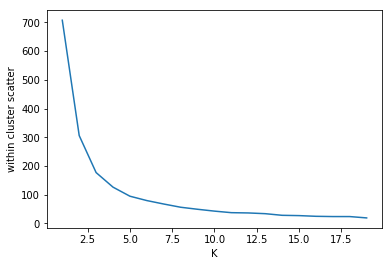

In [17]:
scatters = [within_cluster_scatter(sample_profiles, *clustering) for clustering in kmeans_clusterings]
plt.plot(k_values, scatters)
plt.xlabel("K")
plt.ylabel("within cluster scatter")
plt.show()

## PROBLEM 5: AIC selected number of clusters (1 POINT)
What value of $K$ would be selected by using the AIC penalized objective function?

In [18]:
### BEGIN SOLUTION TEMPLATE=aic_k=?
M = 2
aic_values = [scatter + 2 * k * M for k, scatter in zip(k_values, scatters)]
aic_k = k_values[aic_values.index(min(aic_values))]
### END SOLUTION

In [19]:
# test for aic_k
assert isinstance(aic_k, int)
### BEGIN HIDDEN TESTS
assert aic_k == 11
### END HIDDEN TESTS

## PROBLEM 6: BIC selected number of clusters (1 POINT)
What value of $K$ would be selected by using the BIC penalized objective function?

In [20]:
### BEGIN SOLUTION TEMPLATE=bic_k=?
M = 2
N = len(sample_profiles)
bic_values = [scatter + math.log(N) * k * M for k, scatter in zip(k_values, scatters)]
bic_k = k_values[bic_values.index(min(bic_values))]
### END SOLUTION

In [21]:
# test for bic_k
assert isinstance(bic_k, int)
### BEGIN HIDDEN TESTS
assert bic_k == 8
### END HIDDEN TESTS